# Quantum Random Access Optimization (QRAO) for Maxcut problem

In this tutorial, we will explain the quantum optimization algorithm called Quantum Random Access Optimization (QRAO)[1].

In the usual QAOA ($(1,1,1)$-QRAO), the optimization problem is encoded in the Ising Hamiltonian. 
In this case, the problem Hamiltonian uses only the Pauli $Z$ operator, but in QRAO, the problem Hamiltonian is constructed using not only Pauli $Z$, but also Pauli $X$ and $Y$.
The Hamiltonian constructed by QRAO is called a relaxed Hamiltonian because the ground state of the relaxed Hamiltonian is not the optimal solution to the original problem.

Several QRAOs have been proposed. The following QRAOs are supported by Qamomile.

| algorithm name | `class name` |
| ---- | ---- |
| $(3,1,p)$-QRAO [1] | [`QRAC31Converter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao31/index.html) |
| $(2,1,p)$-QRAO [1] | [`QRAC21Converter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao21/index.html) |
| $(3,2,p)$-QRAO [2] | [`QRAC32Converter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao32/index.html) |
| Space Compression Ratio Preserving QRAO [2] | [`QRACSpaceEfficientConverter`](https://jij-inc.github.io/Qamomile/autoapi/core/converters/qrao/qrao_space_efficient/index.html) |

The API documentation explains how each algorithm constructs a relaxed Hamiltonian.

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import jijmodeling as jm
import jijmodeling_transpiler.core as jmt
import qamomile.core as qm
import qamomile.qiskit as qm_qk

# Create problem data and mathematical model
First, we will create the problem data to be solved.

Here, we will solve the maxcut problem for a 3-regular graph, in the same way as [1].

In [119]:
def Maxcut_problem() -> jm.Problem:
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    x = jm.BinaryVar("x", shape=(V,))
    e = jm.Element("e", belong_to=E)
    i = jm.Element("i", belong_to=V)
    j = jm.Element("j", belong_to=V)

    problem = jm.Problem("Maxcut", sense=jm.ProblemSense.MAXIMIZE)
    si = 2 * x[e[0]] - 1
    sj = 2 * x[e[1]] - 1
    si.set_latex("s_{e[0]}")
    sj.set_latex("s_{e[1]}")
    obj = 1 / 2 * jm.sum(e,  (1 - si * sj))
    problem += obj
    return problem

problem = Maxcut_problem()
problem

We will create a problem with 12 nodes.

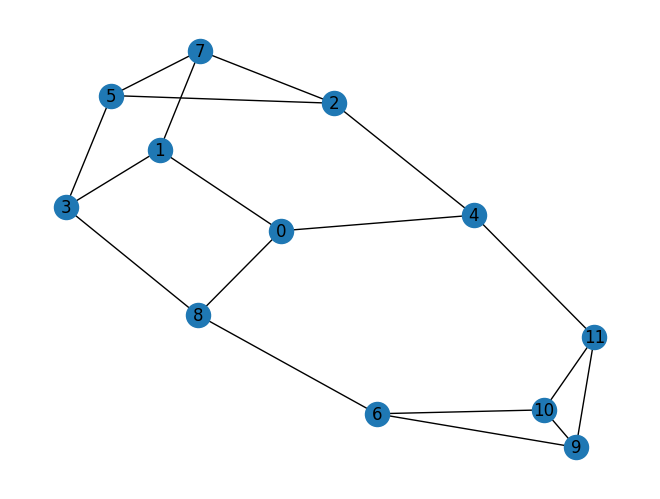

In [100]:
graph = nx.random_regular_graph(3, 12)
nx.draw(graph, with_labels=True)

# Create QRAO Hamiltonian
From here, we will create the relaxed Hamiltonian for QRAO.

First, use `jijmodeling_transpiler` to create a compiled_instance

In [101]:
compiled_instance = jmt.compile_model(problem, {"E": list(graph.edges), "V": len(graph.nodes)})

Next, use `QRAC31Converter` to create a relaxed Hamiltonian.

In [102]:
from qamomile.core.converters.qrao.qrao31 import QRAC31Converter

# Initialize with a compiled optimization problem instance
qrao_converter = QRAC31Converter(compiled_instance, normalize_model=False)

# Generate relaxed Hamiltonian
qrao31_hamiltonian = qrao_converter.get_cost_hamiltonian()
qrao31_hamiltonian

Hamiltonian((Z0, Z1): 1.5, (Z0, Z2): 1.5, (Z0, X2): 1.5, (Z1, X2): 1.5, (Z1, Z2): 1.5, (X0, X1): 1.5, (X0, Y1): 1.5, (X0, Z3): 1.5, (Y0, X1): 1.5, (X1, Y2): 1.5, (Y2, Z3): 1.5, (Y2, X3): 1.5, (Z2, Z3): 1.5, (Y1, Z4): 1.5, (Y0, Z4): 1.5, (X3, Z4): 1.5, (Y1, X2): 1.5, (Y0, X3): 1.5)

Since we will use VQE in QRAO, we will create an VQE ansatz.
We can create a simple ansatz using `create_efficient_su2_circuit`.

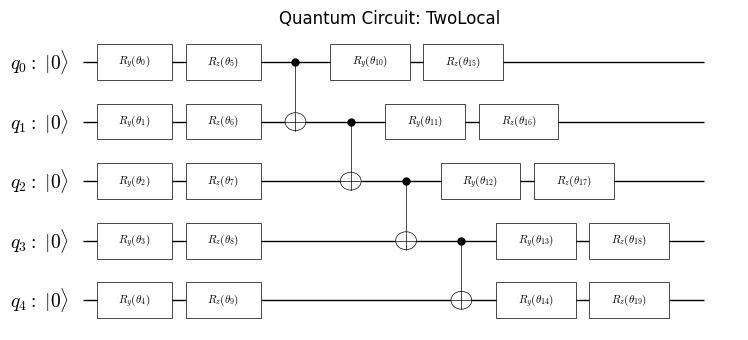

In [104]:
from qamomile.core.ansatz.efficient_su2 import create_efficient_su2_circuit
from qamomile.core.circuit.drawer import plot_quantum_circuit

ansatz = create_efficient_su2_circuit(qrao31_hamiltonian.num_qubits, rotation_blocks = ["ry", "rz"], reps = 1)
plot_quantum_circuit(ansatz)

Above qamomile Hamiltonian and circuit can be converted into Qiskit Hamiltonian and circuit using `QiskitTranspiler`

In [105]:
qk_transpiler = qm_qk.QiskitTranspiler()
qk_ansatz = qk_transpiler.transpile_circuit(ansatz)
qk_qrao31_hamiltonian = qk_transpiler.transpile_hamiltonian(qrao31_hamiltonian)

You can also create QAOA Hamiltonian using `QAOAConverter`.


In [106]:
from qamomile.core.converters.qaoa import QAOAConverter
qaoa_hamiltonian = QAOAConverter(compiled_instance, normalize_model=False).get_cost_hamiltonian()
qk_qaoa_hamiltonian = qk_transpiler.transpile_hamiltonian(qaoa_hamiltonian)

In [122]:
print("The compression ratio of this problem is ", qaoa_hamiltonian.num_qubits / qrao31_hamiltonian.num_qubits)

The compression ratio of this problem is  2.4


# Obtain grand state of the relaxed Hamiltonian
We have created the relaxed Hamiltonian and VQE ansatz, so let us run VQE using qiskit.


In [108]:
import qiskit.primitives as qk_pr
import numpy as np
from scipy.optimize import minimize

cost_history = []
def cost_estimator(param_values):
    estimator = qk_pr.StatevectorEstimator()
    job = estimator.run([(qk_ansatz, qk_qrao31_hamiltonian, param_values)])
    result = job.result()[0]
    cost = result.data['evs']
    cost_history.append(cost)
    return cost

initial_params = np.random.uniform(0, np.pi, len(qk_ansatz.parameters))

# Run QAOA optimization
result = minimize(
    cost_estimator,
    initial_params,
    method="COBYLA",
    options={"maxiter": 10000},
)
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -9.4649972737437
       x: [ 3.075e+00  1.912e+00 ... -3.416e-03  4.928e-05]
    nfev: 10000
   maxcv: 0.0


Let's also check the optimal value using diagonalization and plot them.

In [109]:
from scipy.sparse.linalg import eigsh

qrao_eigvals = eigsh(qk_qrao31_hamiltonian.to_matrix(), k=1, which='SA', return_eigenvectors=False)
qaoa_eigvals = eigsh(qk_qaoa_hamiltonian.to_matrix(), k=1, which='SA', return_eigenvectors=False)

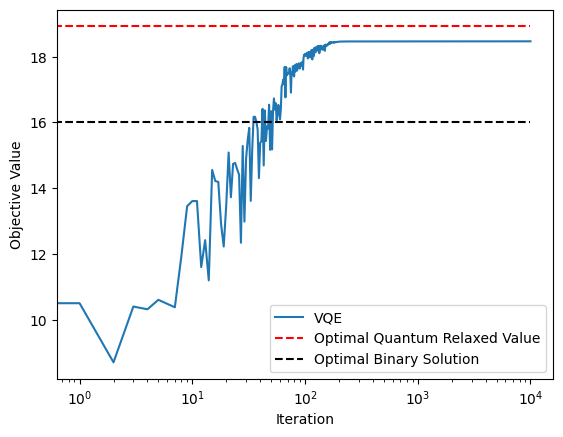

In [110]:
plt.plot(- (np.array(cost_history) + qrao31_hamiltonian.constant), label = "VQE")
plt.hlines(-(qrao_eigvals + qrao31_hamiltonian.constant), 0, len(cost_history), linestyles="dashed", label="Optimal Quantum Relaxed Value",colors="red")
plt.hlines(-(qaoa_eigvals + qrao31_hamiltonian.constant), 0, len(cost_history), linestyles="dashed", label="Optimal Binary Solution",colors="black")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.xscale("log")
plt.legend(loc="lower right")
plt.show()

This is quite similar to Fig. 2 in [1].

# Pauli Rounding

As we mentioned, the ground state of the relaxed Hamiltonian is not classical optimal solution.
We need the rounding algorithm to decode the classical solution from the quantum state.

[1] proposed two rounding algorithms, Pauli Rounding and Magic State Rounding.
In this tutorial, we use Puali Rounding to decode the classical solution.

We can get Pauli Operators list using `get_encoded_pauli_list`.
The order of the Pauli operators corresponds to the order of the corresponding encoded variables.

In [111]:
pauli_list = qrao_converter.get_encoded_pauli_list()
print(pauli_list)

[Hamiltonian((Z0,): 1.0), Hamiltonian((Z1,): 1.0), Hamiltonian((Z2,): 1.0), Hamiltonian((X2,): 1.0), Hamiltonian((X0,): 1.0), Hamiltonian((X1,): 1.0), Hamiltonian((Y1,): 1.0), Hamiltonian((Z3,): 1.0), Hamiltonian((Y0,): 1.0), Hamiltonian((Y2,): 1.0), Hamiltonian((X3,): 1.0), Hamiltonian((Z4,): 1.0)]


We can calculate the expecation value of this.

In [113]:
qiskit_pauli_list = [qk_transpiler.transpile_hamiltonian(pauli) for pauli in pauli_list]

estimator = qk_pr.StatevectorEstimator()
job = estimator.run([(qk_ansatz, pauli, result.x) for pauli in qiskit_pauli_list])
rounded_values = [np.sign(_res.data['evs']) for _res in job.result()]
binary_values = [(1 - _val) // 2 for _val in rounded_values]
binary_values

[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0]

We can map this bianry variable result into `sampleset` using `decode_bits_to_sampleset`.

In [114]:
bitsample = qm.BitsSample(1,binary_values)
sampleset = qrao_converter.decode_bits_to_sampleset(qm.BitsSampleSet([bitsample]))

Finally, we have result!
Let us visualize it.

In [115]:
def get_edge_colors(
    graph, cut_solution, in_cut_color="r", not_in_cut_color="b"
):
    cut_set_1 = [node[0] for node, value in cut_solution.items() if value == 1.0]
    cut_set_2 = [node for node in graph.nodes() if node not in cut_set_1]

    edge_colors = []
    for u, v, _ in graph.edges(data=True):
        if (u in cut_set_1 and v in cut_set_2) or (u in cut_set_2 and v in cut_set_1):
            edge_colors.append(in_cut_color)
        else:
            edge_colors.append(not_in_cut_color)
    node_colors = ["#2696EB" if node in cut_set_1 else "#EA9b26" for node in graph.nodes()]
    return edge_colors, node_colors

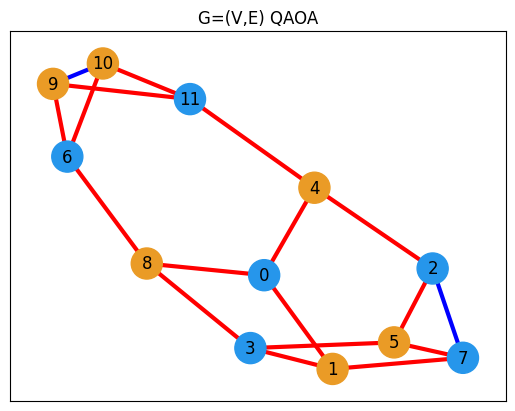

In [116]:
best_values = sampleset[0].var_values["x"].values
edge_colors, node_colors = get_edge_colors(graph, best_values)
edge_labels = nx.get_edge_attributes(graph, "weight")

plt.title("G=(V,E) QAOA")
plt.plot(figsize=(5, 4))
nx.draw_networkx(
    graph,
    node_size=500,
    width=3,
    with_labels=True,
    edge_color=edge_colors,
    node_color=node_colors,
)


# References
[1] Bryce Fuller, Charles Hadfield, Jennifer R. Glick, Takashi Imamichi, Toshinari Itoko, Richard J. Thompson, Yang Jiao, Marna M. Kagele, Adriana W. Blom-Schieber, Rudy Raymond, and Antonio Mezzacapo. Approximate solutions of combinatorial problems via quantum relaxations. IEEE Transactions on Quantum Engineering, 5():1–15, 2024. doi:10.1109/TQE.2024.3421294.

[2] Kosei Teramoto, Rudy Raymond, Eyuri Wakakuwa, and Hiroshi Imai. Quantum-relaxation based optimization algorithms: theoretical extensions. 2023. URL: https://arxiv.org/abs/2302.09481, arXiv:2302.09481.